# Tradutor Português/Inglês utilizando Transformers

## Setup

In [129]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

os.environ['KERAS_BACKEND'] = 'tensorflow'

import keras
from keras import layers
import tensorflow as tf

## Carregamento dos Dados

In [130]:
# Vamos usar listas normais do Python, que são perfeitas para isso.
portuguese_sentences = []
english_sentences = []

# O 'with open(...)' garante que o arquivo seja fechado corretamente no final.
with open('por.txt', 'r', encoding='utf-8') as f:
    for line in f:
        # Ignora linhas em branco que possam existir no arquivo
        if not line.strip():
            continue

        # 1. strip() remove espaços/quebras de linha no início/fim
        # 2. split('\t') quebra a linha no caractere de tabulação
        english_part, portuguese_part = line.strip().split('\t')

        portuguese_sentences.append(portuguese_part)
        english_sentences.append(english_part)

# Vamos conferir as 3 primeiras frases de cada lista para ver se deu certo
print("Portuguese sentences:", portuguese_sentences[:3])
print("English sentences:", english_sentences[:3])

Portuguese sentences: ['Vá.', 'Oi.', 'Corra!']
English sentences: ['Go.', 'Hi.', 'Run!']


## Pré-Processamento: Limpeza, Padronização e Transformação

In [131]:
# Let's keep our original lists for comparison
# portuguese_sentences = ['Vá.', 'Oi.', 'Corra!', ...]
# english_sentences = ['Go.', 'Hi.', 'Run!', ...]

def standardize_text(text):
    """
    Cleans and standardizes a single sentence.
    1. Converts to lowercase.
    2. Removes punctuation.
    3. Removes extra whitespace.
    """
    # Lowercase the text
    text = text.lower()
    
    # Create a translation table to remove punctuation
    # string.punctuation contains characters like '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# 1. Standardize the source (Portuguese) and target (English) phrases
source_phrases_clean = [standardize_text(pt) for pt in portuguese_sentences]
target_phrases_clean = [standardize_text(en) for en in english_sentences]

# 2. NOW, add the special tokens to the CLEANED target phrases
target_phrases_final = [f'[start] {eng} [end]' for eng in target_phrases_clean]

# Let's see the transformation for one example
print(f"Original English phrase: '{english_sentences[2]}'")
print(f"Final target phrase:   '{target_phrases_final[2]}'")
print("-" * 20)
print("Final source phrases (first 3):", source_phrases_clean[:3])
print("Final target phrases (first 3):", target_phrases_final[:3])


Original English phrase: 'Run!'
Final target phrase:   '[start] run [end]'
--------------------
Final source phrases (first 3): ['vá', 'oi', 'corra']
Final target phrases (first 3): ['[start] go [end]', '[start] hi [end]', '[start] run [end]']


## Vetorização

In [132]:
# We'll set a vocabulary size and a maximum sequence length
# (even though our phrases are short, this is good practice)
vocab_size = 500
sequence_length = 20

# Create the vectorization layer for the source language (Portuguese)
source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_sequence_length=sequence_length,
    standardize=None  # No standardization - we already did it manually
)

# Create the vectorization layer for the target language (English)
# Use None for standardization since we already pre-processed the text
# This will preserve the brackets in [start] and [end]
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_sequence_length=sequence_length,
    standardize=None  # No standardization - we already did it manually and kept brackets
)

# Train the layers on our datasets to build their vocabularies
# Note: We use the cleaned source phrases and the FINAL target phrases
# (the ones with [start] and [end])
source_vectorization.adapt(source_phrases_clean)
target_vectorization.adapt(target_phrases_final)

# Let's test it on one example
test_phrase_pt = source_phrases_clean[10] # "eu entendo"
vectorized_pt = source_vectorization([test_phrase_pt])

test_phrase_en = target_phrases_final[10] # "[start] i see [end]"
vectorized_en = target_vectorization([test_phrase_en])

print(f"Original Portuguese phrase: '{test_phrase_pt}'")
print(f"Vectorized Portuguese: {vectorized_pt.numpy()}")
print("-" * 20)
print(f"Original English phrase: '{test_phrase_en}'")
print(f"Vectorized English: {vectorized_en.numpy()}")

# You can also see the vocabulary it created
pt_vocab = source_vectorization.get_vocabulary()
en_vocab = target_vectorization.get_vocabulary()
print("\nSome words from the Portuguese vocabulary:", pt_vocab[:10])
print("Some words from the English vocabulary:", en_vocab[:10])
print(f"\nVerificando tokens especiais:")
print(f"'[start]' no vocabulário: {'[start]' in en_vocab}")
print(f"'[end]' no vocabulário: {'[end]' in en_vocab}")


Original Portuguese phrase: 'eu entendo'
Vectorized Portuguese: [[  2 217   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]]
--------------------
Original English phrase: '[start] i see [end]'
Vectorized English: [[ 2  4 71  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]

Some words from the Portuguese vocabulary: ['', '[UNK]', np.str_('eu'), np.str_('está'), np.str_('é'), np.str_('o'), np.str_('você'), np.str_('que'), np.str_('não'), np.str_('isso')]
Some words from the English vocabulary: ['', '[UNK]', np.str_('[start]'), np.str_('[end]'), np.str_('i'), np.str_('the'), np.str_('is'), np.str_('you'), np.str_('a'), np.str_('it')]

Verificando tokens especiais:
'[start]' no vocabulário: True
'[end]' no vocabulário: True


## Positional Encoding

In [133]:
class PositionalEncoding(layers.Layer):
    """
    This layer injects positional information into the input embeddings.
    It's a fixed, non-learnable layer.
    """
    def __init__(self, max_length, d_model):
        super().__init__()
        self.d_model = d_model # Dimension of the embedding vector
        self.max_length = max_length # Maximum possible length of a sequence

        # Create a positional encoding matrix of shape (max_length, d_model)
        # This matrix is pre-calculated and will not change during training.
        
        # Create a tensor representing positions (0, 1, ..., max_length-1)
        # Shape: (max_length, 1)
        positions = tf.range(start=0, limit=max_length, delta=1, dtype=tf.float32)
        positions = tf.expand_dims(positions, axis=1)

        # Calculate the denominator term in the formula.
        # 2i/d_model --> [0, 2, 4, ..., d_model-2] / d_model
        div_term = tf.exp(tf.range(0, d_model, 2, dtype=tf.float32) * -(np.log(10000.0) / d_model))

        # Calculate the angles for the sine and cosine functions
        # Broadcasting (positions * div_term) results in a shape of (max_length, d_model/2)
        angles = positions * div_term

        # Calculate sine for even indices and cosine for odd indices
        sin_values = tf.sin(angles)
        cos_values = tf.cos(angles)
        
        # Interleave the sine and cosine values.
        # For example, if sin=[s1,s2] and cos=[c1,c2], the result is [s1,c1,s2,c2]
        # This creates the final positional encoding matrix.
        # Shape: (max_length, d_model)
        pe = tf.stack([sin_values, cos_values], axis=2)  # Shape: (max_length, d_model/2, 2)
        pe = tf.reshape(pe, [max_length, d_model])       # Shape: (max_length, d_model)
        
        # Store as TensorFlow constant for better integration
        self.positional_encoding = tf.constant(pe, dtype=tf.float32)

    def call(self, x):
        """
        The forward pass of the layer.
        Args:
            x: Input embeddings. Shape: (batch_size, sequence_length, d_model)
        Returns:
            Embeddings with added positional information.
        """
        # Get the length of the input sequence as a Python int
        seq_length = x.shape[1] if x.shape[1] is not None else tf.shape(x)[1]
        
        # Add the positional encoding to the input embeddings.
        # We only use the part of the PE matrix that corresponds to the sequence length.
        # Use tf.slice for dynamic slicing which works with both static and dynamic shapes
        pos_encoding = tf.slice(self.positional_encoding, [0, 0], [seq_length, self.d_model])
        
        return x + tf.cast(pos_encoding, dtype=x.dtype)

In [134]:
# --- Configuration ---
vocab_size = 1000
d_model = 128 # The dimension of our embedding vectors
max_length = 50 # The maximum length of a sentence

# --- Create dummy input data ---
# Imagine this is one batch of vectorized sentences
dummy_input = tf.random.uniform((2, 15), maxval=vocab_size, dtype=tf.int64) # Batch of 2 sentences, length 15

# --- Build and run the layers ---
embedding_layer = layers.Embedding(input_dim=vocab_size, output_dim=d_model)
positional_encoding_layer = PositionalEncoding(max_length=max_length, d_model=d_model)

# 1. Pass input through the embedding layer
word_embeddings = embedding_layer(dummy_input)

# 2. Add positional information
final_embeddings = positional_encoding_layer(word_embeddings)

print("Shape of word embeddings:", word_embeddings.shape)
print("Shape of final embeddings (with positional info):", final_embeddings.shape)

Shape of word embeddings: (2, 15, 128)
Shape of final embeddings (with positional info): (2, 15, 128)


## Self-Attention

In [135]:
# --- Configuration ---
d_model = 128
num_heads = 8

# The dimension of each head is d_model / num_heads
key_dim = d_model // num_heads

# --- Create dummy input data ---
# Batch of 2 sentences, length 15, embedding dim 128
dummy_input = tf.random.uniform((2, 15, d_model))

# --- Build and run the layer ---
mha_layer = layers.MultiHeadAttention(
    num_heads=num_heads,
    key_dim=key_dim,
    output_shape=d_model # Ensures the output dimension is correct
)

# In self-attention, query, value, and key are the same.
output_keras = mha_layer(query=dummy_input, value=dummy_input, key=dummy_input)

print("Shape of the input:", dummy_input.shape)
print("Shape of the output (from Keras MHA):", output_keras.shape)

Shape of the input: (2, 15, 128)
Shape of the output (from Keras MHA): (2, 15, 128)


## Encoder Block

In [136]:
# --- Encoder Block Configuration ---
d_model = 128      # Dimension of the model (embedding size)
num_heads = 8      # Number of attention heads
dff = 512          # Dimension of the inner-layer in the Feed-Forward Network
dropout_rate = 0.1 # Dropout rate for regularization

class EncoderBlock(layers.Layer):
    """
    Represents one block of the Transformer's Encoder.
    It consists of Multi-Head Attention and a Feed-Forward Network,
    with residual connections and layer normalization.
    """
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()

        # Multi-Head Attention Layer
        self.mha = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
            output_shape=d_model
        )

        # Feed-Forward Network (consists of two dense layers)
        self.ffn = keras.Sequential([
            layers.Dense(dff, activation='relu'), # (batch_size, seq_len, dff)
            layers.Dense(d_model)                 # (batch_size, seq_len, d_model)
        ])

        # Layer Normalization
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        # Dropout for regularization
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, training, mask=None):
        # 1. Multi-Head Attention sub-layer
        # The input 'x' is used for query, key, and value in self-attention
        attn_output = self.mha(query=x, value=x, key=x, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        # Residual connection and Layer Normalization
        out1 = self.layernorm1(x + attn_output)

        # 2. Feed-Forward Network sub-layer
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        # Residual connection and Layer Normalization
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

# --- Test the EncoderBlock ---
encoder_block = EncoderBlock(d_model=d_model, num_heads=num_heads, dff=dff)

# Create some dummy input (output from positional encoding)
dummy_input = tf.random.uniform((2, 15, d_model)) # (batch_size, sequence_length, d_model)

# The call method requires a 'training' flag for dropout
output_from_block = encoder_block(dummy_input, training=False)

print("Shape of the input to the Encoder Block:", dummy_input.shape)
print("Shape of the output from the Encoder Block:", output_from_block.shape)

Shape of the input to the Encoder Block: (2, 15, 128)
Shape of the output from the Encoder Block: (2, 15, 128)


## Encoder

In [137]:
class Encoder(layers.Layer):
    """
    The complete Encoder, consisting of an embedding layer, positional encoding,
    and a stack of N EncoderBlocks.
    """
    def __init__(self, num_layers, d_model, num_heads, dff,
                 input_vocab_size, max_length, rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        # Input Embedding layer
        self.embedding = layers.Embedding(input_vocab_size, d_model)
        
        # Positional Encoding layer
        self.pos_encoding = PositionalEncoding(max_length, self.d_model)

        # Stack of EncoderBlocks
        # We use a list comprehension to create N encoder blocks
        self.enc_layers = [EncoderBlock(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]

        # Dropout layer for regularization
        self.dropout = layers.Dropout(rate)

    def call(self, x, training=False, mask=None):
        seq_len = tf.shape(x)[1]

        # 1. Get embeddings
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        
        # A scaling factor is applied to the embeddings as in the original paper
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

        # 2. Add positional encoding
        x = self.pos_encoding(x)

        # 3. Apply dropout
        x = self.dropout(x, training=training)

        # 4. Pass through the stack of encoder blocks
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)

        return x  # (batch_size, input_seq_len, d_model)

# --- Test the complete Encoder ---

# Configuration for a small encoder
num_layers_encoder = 2 # Let's stack 2 blocks for this test
d_model = 128
num_heads = 8
dff = 512
input_vocab_size = len(source_vectorization.get_vocabulary()) # Get vocab size from our layer
max_sentence_length = 20

# Create an instance of the Encoder
encoder = Encoder(num_layers=num_layers_encoder,
                  d_model=d_model,
                  num_heads=num_heads,
                  dff=dff,
                  input_vocab_size=input_vocab_size,
                  max_length=max_sentence_length)

# Create some dummy input (vectorized portuguese sentences)
# Batch of 2 sentences, length 20
dummy_pt_vector = source_vectorization(["eu amo pizza", "onde fica o banheiro"])

# Get the output from the encoder
encoder_output = encoder(dummy_pt_vector, training=False)

print("Shape of the input to the Encoder (vectorized text):", dummy_pt_vector.shape)
print("Shape of the output from the Encoder (context vectors):", encoder_output.shape)

Shape of the input to the Encoder (vectorized text): (2, 20)
Shape of the output from the Encoder (context vectors): (2, 20, 128)


## Decoder Block

In [138]:
# This code builds on the previous cells in your notebook.
# Make sure you have run the cells defining d_model, num_heads, dff etc.

class DecoderBlock(layers.Layer):
    """
    Represents one block of the Transformer's Decoder.
    It consists of Masked Multi-Head Self-Attention, Cross-Attention,
    and a Feed-Forward Network.
    """
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()

        # 1. Masked Multi-Head Self-Attention (looks at the target sequence)
        self.mha1 = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
            output_shape=d_model
        )

        # 2. Multi-Head Cross-Attention (looks at the encoder output)
        self.mha2 = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
            output_shape=d_model
        )

        # 3. Feed-Forward Network
        self.ffn = keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)
        ])

        # Layer Normalization layers
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)

        # Dropout layers
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.dropout3 = layers.Dropout(rate)

    def call(self, x, encoder_output, training, look_ahead_mask, padding_mask=None):
        # Sub-layer 1: Masked Multi-Head Self-Attention
        # The decoder attends to itself, but can't see future tokens.
        attn1 = self.mha1(query=x, value=x, key=x, attention_mask=look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(x + attn1)

        # Sub-layer 2: Cross-Attention
        # The decoder attends to the encoder's output.
        # Query comes from the decoder, Key and Value from the encoder.
        attn2 = self.mha2(query=out1, value=encoder_output, key=encoder_output, attention_mask=padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(out1 + attn2)

        # Sub-layer 3: Feed-Forward Network
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(out2 + ffn_output)

        return out3

# --- Test the DecoderBlock ---
# Use the same configuration as the Encoder
d_model = 128
num_heads = 8
dff = 512

decoder_block = DecoderBlock(d_model=d_model, num_heads=num_heads, dff=dff)

# Create dummy inputs
# Note: The sequence lengths for the decoder input and encoder output can be different.
dummy_decoder_input = tf.random.uniform((2, 15, d_model)) # (batch_size, target_seq_len, d_model)
dummy_encoder_output = tf.random.uniform((2, 20, d_model)) # (batch_size, input_seq_len, d_model)

# For testing shapes, we can pass masks as None
output_from_block = decoder_block(
    dummy_decoder_input,
    dummy_encoder_output,
    training=False,
    look_ahead_mask=None
)

print("Shape of the decoder input:", dummy_decoder_input.shape)
print("Shape of the encoder output:", dummy_encoder_output.shape)
print("Shape of the output from the Decoder Block:", output_from_block.shape)

Shape of the decoder input: (2, 15, 128)
Shape of the encoder output: (2, 20, 128)
Shape of the output from the Decoder Block: (2, 15, 128)


## Decoder

In [139]:
class Decoder(layers.Layer):
    """
    The complete Decoder, consisting of an embedding layer, positional encoding,
    and a stack of N DecoderBlocks.
    """
    def __init__(self, num_layers, d_model, num_heads, dff,
                 target_vocab_size, max_length, rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        # Input Embedding layer for the target language
        self.embedding = layers.Embedding(target_vocab_size, d_model)

        # Positional Encoding layer
        self.pos_encoding = PositionalEncoding(max_length, d_model)

        # Stack of DecoderBlocks
        self.dec_layers = [DecoderBlock(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]

        # Dropout layer
        self.dropout = layers.Dropout(rate)

    def call(self, x, encoder_output, training=False, look_ahead_mask=None, padding_mask=None):
        seq_len = tf.shape(x)[1]

        # 1. Get embeddings for the target sequence
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

        # 2. Add positional encoding
        x = self.pos_encoding(x)

        # 3. Apply dropout
        x = self.dropout(x, training=training)

        # 4. Pass through the stack of decoder blocks
        for i in range(self.num_layers):
            x = self.dec_layers[i](x, encoder_output, training=training,
                                     look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)

        # The shape of x is (batch_size, target_seq_len, d_model)
        return x

# --- Test the complete Decoder ---

# Use the same configuration as the Encoder
num_layers_decoder = 2 # Let's stack 2 blocks
d_model = 128
num_heads = 8
dff = 512
target_vocab_size = len(target_vectorization.get_vocabulary()) # CORREÇÃO: len() do vocabulário
max_sentence_length = 20

# Create an instance of the Decoder
decoder = Decoder(num_layers=num_layers_decoder,
                  d_model=d_model,
                  num_heads=num_heads,
                  dff=dff,
                  target_vocab_size=target_vocab_size,
                  max_length=max_sentence_length)

# Create dummy inputs
# We need both a dummy decoder input and the dummy encoder output from the previous test
dummy_en_vector = target_vectorization(["[start] i love pizza", "[start] where is the bathroom"])
# We can reuse the encoder_output from the Encoder test cell
# encoder_output has shape (2, 20, 128)

# Get the output from the decoder
decoder_output = decoder(
    x=dummy_en_vector,
    encoder_output=encoder_output, # This comes from the Encoder
    training=False,
    look_ahead_mask=None # Passing None for shape testing
)

print("Shape of the decoder input (vectorized English text):", dummy_en_vector.shape)
print("Shape of the encoder output (context vectors):", encoder_output.shape)
print("Shape of the final decoder output:", decoder_output.shape)

Shape of the decoder input (vectorized English text): (2, 20)
Shape of the encoder output (context vectors): (2, 20, 128)
Shape of the final decoder output: (2, 20, 128)


## Modelo Transformer

In [140]:
class Transformer(keras.Model):
    """
    The complete Transformer model, connecting the Encoder and Decoder.
    """
    def __init__(self, num_layers, d_model, num_heads, dff,
                 input_vocab_size, target_vocab_size, max_length, rate=0.1):
        super().__init__()
        # Instantiate the Encoder
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               input_vocab_size, max_length, rate)

        # Instantiate the Decoder
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, max_length, rate)

        # The final linear layer to project decoder output to vocabulary size
        self.final_layer = layers.Dense(target_vocab_size)

    def call(self, inputs, training=False):
        # The 'inputs' will be a tuple: (source_sequence, target_sequence)
        inp, tar = inputs

        # The encoder doesn't need any mask for this simple setup
        enc_padding_mask = None # For simplicity, we'll ignore padding masks for now
        look_ahead_mask = self.create_look_ahead_mask(tf.shape(tar)[1])
        dec_padding_mask = None # Similarly, ignoring for now

        # 1. Pass the source sequence through the encoder
        encoder_output = self.encoder(inp, training=training, mask=enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # 2. Pass the encoder output and the target sequence through the decoder
        decoder_output = self.decoder(
            tar, encoder_output, training=training, 
            look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask) # (batch_size, tar_seq_len, d_model)

        # 3. Pass the decoder output through the final linear layer
        final_output = self.final_layer(decoder_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output
    
    # This is a helper function to create the look-ahead mask for the decoder
    def create_look_ahead_mask(self, size):
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        return mask  # (seq_len, seq_len)

# --- Test the complete Transformer model ---

# Use the configurations from previous cells
transformer = Transformer(
    num_layers=num_layers_encoder, # Using the same number of layers for both for simplicity
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=len(source_vectorization.get_vocabulary()), # CORREÇÃO: len() do vocabulário
    target_vocab_size=len(target_vectorization.get_vocabulary()), # CORREÇÃO: len() do vocabulário
    max_length=max_sentence_length
)

# Reuse the dummy vectors from previous tests
# dummy_pt_vector shape: (2, 20)
# dummy_en_vector shape: (2, 20)

# The call method expects a tuple of (input, target)
output = transformer((dummy_pt_vector, dummy_en_vector), training=False)

print("Shape of Portuguese input:", dummy_pt_vector.shape)
print("Shape of English input:", dummy_en_vector.shape)
print("Shape of the final Transformer output (logits):", output.shape)

Shape of Portuguese input: (2, 20)
Shape of English input: (2, 20)
Shape of the final Transformer output (logits): (2, 20, 500)


## Função de Perda

In [141]:
# We need to define our loss function and metrics
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none' # 'none' means we get a loss for each example
)

def masked_loss_function(real, pred):
    # Create a mask to identify where the real target is not a padding token (0)
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    
    # Calculate the loss for every token in the batch
    loss_ = loss_object(real, pred)
    
    # Cast the mask to the same type as the loss
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    # Apply the mask to the loss, effectively zeroing out the loss for padding tokens
    loss_ *= mask
    
    # Return the average loss over the non-padded tokens
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

## Learning Rate Schedule

In [142]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# Instantiate the learning rate schedule and the Adam optimizer
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

## Treinamento

In [144]:
# --- 1. Prepare the Data for Training and Validation ---

from sklearn.model_selection import train_test_split

# Ensure eager execution is enabled
tf.config.run_functions_eagerly(True)

# Set a batch size
batch_size = 64 # You can adjust this based on your hardware

# Vectorize all the sentences
source_vectors = source_vectorization(source_phrases_clean)
target_vectors = target_vectorization(target_phrases_final)

# Convert to numpy arrays for sklearn compatibility
source_vectors_np = source_vectors.numpy()
target_vectors_np = target_vectors.numpy()

# Split the data into training and validation sets (80/20 split)
source_train, source_val, target_train, target_val = train_test_split(
    source_vectors_np, target_vectors_np, test_size=0.2, random_state=42
)

print(f"Total examples: {len(source_vectors_np)}")
print(f"Training examples: {len(source_train)}")
print(f"Validation examples: {len(source_val)}")

# Helper function to create datasets
def create_dataset(source, target):
    """Helper function to create a tf.data.Dataset with shifted targets."""
    # The input to the decoder is the target sequence without the last token
    decoder_inputs = target[:, :-1]
    # The target for the loss function is the target sequence without the first token
    decoder_outputs = target[:, 1:]
    
    # Create the tf.data.Dataset object
    dataset = tf.data.Dataset.from_tensor_slices(
        ((source, decoder_inputs), decoder_outputs)
    )
    # Shuffle, batch, and prefetch
    return dataset.shuffle(buffer_size=len(source)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Create the training and validation datasets
train_dataset = create_dataset(source_train, target_train)
val_dataset = create_dataset(source_val, target_val)

# --- 2. Compile the Model ---

# We need a metric to monitor performance, let's create a masked accuracy
def masked_accuracy(real, pred):
    # Get the predicted word by finding the index with the highest logit
    pred = tf.argmax(pred, axis=2)
    real = tf.cast(real, pred.dtype)
    
    # Check for matches
    match = tf.cast(real == pred, dtype=tf.float32)
    
    # Create the padding mask
    mask = tf.cast(tf.math.logical_not(tf.math.equal(real, 0)), dtype=tf.float32)
    
    # Apply the mask to the matches
    match *= mask
    
    # Calculate the accuracy on non-padded tokens
    return tf.reduce_sum(match) / tf.reduce_sum(mask)

# Compile the model with the optimizer, loss, and metric
transformer.compile(
    optimizer=optimizer,
    loss=masked_loss_function,
    metrics=[masked_accuracy],
    run_eagerly=True  # Run in eager mode to avoid graph mode issues
)

# --- 3. Configure Early Stopping ---

from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping: para o treinamento se val_loss não melhorar por 'patience' épocas
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitora a perda de validação
    patience=10,                   # Espera 10 épocas sem melhora antes de parar
    restore_best_weights=True,    # Restaura os pesos da melhor época
    verbose=1,                    # Mostra mensagens quando parar
    mode='min'                    # 'min' porque queremos minimizar a loss
)

# --- 4. Train the Model with Validation and Early Stopping ---

print("Starting training with validation and Early Stopping...")
print("Training will stop automatically if validation loss doesn't improve for 10 epochs.")
print("-" * 60)

# Definimos mais épocas, mas o early stopping pode parar antes
epochs = 100

history = transformer.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping]  # Adiciona o callback de Early Stopping
)

print("\n" + "=" * 60)
print("Training finished!")
print(f"Total epochs trained: {len(history.history['loss'])}")
print("=" * 60)


Total examples: 1000
Training examples: 800
Validation examples: 200
Starting training with validation and Early Stopping...
Training will stop automatically if validation loss doesn't improve for 10 epochs.
------------------------------------------------------------
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 612ms/step - loss: 6.0614 - masked_accuracy: 0.0096 - val_loss: 5.9836 - val_masked_accuracy: 0.0234
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 612ms/step - loss: 6.0614 - masked_accuracy: 0.0096 - val_loss: 5.9836 - val_masked_accuracy: 0.0234
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 603ms/step - loss: 5.8628 - masked_accuracy: 0.0567 - val_loss: 5.7340 - val_masked_accuracy: 0.1714
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 603ms/step - loss: 5.8628 - masked_accuracy: 0.0567 - val_loss: 5.7340 - val_masked_accuracy: 0.1714
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 589ms/step - loss: 5.5900 - masked_accuracy: 0.2006 - val_loss: 5.4583 - val_masked_accuracy: 0.2150
Epoch 4/100
13/1

## Visualização das Curvas de Aprendizagem

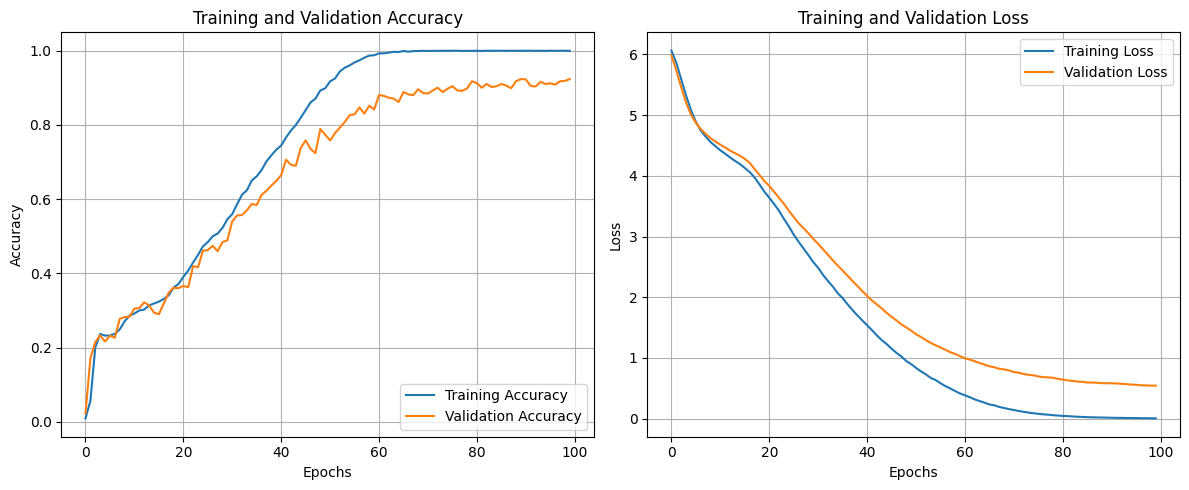


Final Training Loss: 0.0050
Final Validation Loss: 0.5437
Final Training Accuracy: 0.9995
Final Validation Accuracy: 0.9236


In [145]:
# Get the training history
train_acc = history.history['masked_accuracy']
val_acc = history.history['val_masked_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create the epochs range
epochs_range = range(len(train_acc))

# Plot the training and validation curves
plt.figure(figsize=(12, 5))

# --- Plot Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# --- Plot Loss ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\nFinal Training Loss: {train_loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")
print(f"Final Training Accuracy: {train_acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")


## Inferência

In [ ]:
# Get the target vocabulary
target_vocab = target_vectorization.get_vocabulary()

# Create a dictionary to map the target language index back to a word
index_to_word = {i: word for i, word in enumerate(target_vocab)}

# Define the maximum length for a generated translation
max_output_length = 20

# Find the indices for start and end tokens (with brackets preserved)
start_token_index = target_vocab.index('[start]')
end_token_index = target_vocab.index('[end]')

print(f"Token '[start]' tem índice: {start_token_index}")
print(f"Token '[end]' tem índice: {end_token_index}")

def translate(sentence, debug=False):
    """
    Translates a Portuguese sentence to English using the trained Transformer model.
    """
    # 1. Preprocess the input sentence
    cleaned_sentence = standardize_text(sentence)
    
    # 2. Vectorize the sentence and add a batch dimension
    input_vector = source_vectorization([cleaned_sentence]) # Shape: (1, sequence_length)
    
    if debug:
        print(f"  Input vectorizado: {input_vector.numpy()}")
    
    # 3. Initialize the decoder's input with the '[start]' token
    # The decoder input starts as a tensor with the start token index
    decoder_input = tf.constant([[start_token_index]], dtype=tf.int64)

    generated_tokens = []
    for i in range(max_output_length):
        # 4. Get the model's predictions
        # The model is called in a non-training mode
        predictions = transformer((input_vector, decoder_input), training=False)
        
        # 5. Get the logits for the very last predicted token
        # predictions shape: (batch_size, seq_len, vocab_size) -> (1, i+1, vocab_size)
        # We want the predictions for the last token in the sequence
        last_token_logits = predictions[:, -1, :] # Shape: (1, vocab_size)
        
        # 6. Find the token with the highest probability (greedy search)
        predicted_id = tf.argmax(last_token_logits, axis=-1) # Shape: (1,)
        predicted_id_value = int(predicted_id.numpy()[0])
        
        if debug:
            print(f"  Step {i}: Predicted token ID = {predicted_id_value}, word = '{index_to_word.get(predicted_id_value, '???')}'")
        
        generated_tokens.append(predicted_id_value)
        
        # 7. Add the predicted token to the decoder input for the next iteration
        decoder_input = tf.concat([decoder_input, [predicted_id]], axis=1)
        
        # 8. Check if the predicted token is the '[end]' token
        if predicted_id_value == end_token_index:
            if debug:
                print(f"  Token '[end]' found, stopping generation.")
            break
            
    # 9. Convert the sequence of token IDs back to words
    # We ignore the [start] and [end] tokens
    output_tokens = [token for token in generated_tokens if token != end_token_index]
    translated_text = " ".join(index_to_word[token] for token in output_tokens)
    
    return translated_text

# --- Let's try it out! ---
# Use some sentences from our dataset to see if it learned
print("\n" + "="*40)
print("Original PT: 'por que eu'")
print("Translation EN:", translate("por que eu", debug=True))
print("-" * 40)
print("Original PT: 'eu venci'")
print("Translation EN:", translate("eu venci"))
print("-" * 20)
print("Original PT: 'socorro'")
print("Translation EN:", translate("socorro"))
print("-" * 20)

# Try a new sentence it has never seen (but with words from the vocabulary)
print("Original PT (New): 'eu te entendo'")
print("Translation EN (New):", translate("eu te entendo"))


Token '[start]' tem índice: 2
Token '[end]' tem índice: 3

Original PT: 'por que eu'
  Input vectorizado: [[11  9  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
  Step 0: Predicted token ID = 21, word = 'listen'
  Step 1: Predicted token ID = 3, word = '[end]'
  Token '[end]' found, stopping generation.
Translation EN: listen
----------------------------------------
Original PT: 'eu venci'
Translation EN: listen
--------------------
Original PT: 'socorro'
Translation EN: listen
--------------------
Original PT (New): 'eu te entendo'
Translation EN (New): listen
Translation EN: listen
--------------------
Original PT (New): 'eu te entendo'
Translation EN (New): listen
